# Setting

In [ ]:
!pip install --upgrade prince

In [ ]:
!pip install faker prince

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import random
import uuid
from datetime import datetime, timedelta
import json
import faker
import warnings

import pandas as pd
import prince
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D 플롯을 위한 모듈 import
import seaborn as sns
import plotly.express as px

In [ ]:
%matplotlib inline
plt.rc('font', family='NanumBarunGothic')

warnings.filterwarnings('ignore')

In [ ]:
pd.set_option('display.max_columns', None)  # Display all columns

# 1. Preprocessing ~ EDA

## 샘플 데이터

In [ ]:
df = pd.read_csv('/content/synthetic_transaction_data.csv')
df.head()

,transaction_time,TransactionDT,recipient,TransactionAmt,hour,voice_match,DeviceInfo,region,receiver_bank,receiver_account,is_new_account_for_user,avg_amount_to_bank,amount_ratio_to_bank_avg,is_nighttime,recent_transaction_gap,is_new_device,ip_address,vpn,payment_method,intent,authentication,app_version,rooting
0,2025-01-14 09:56:23,86400,춘자,68500.0,9,True,Unknown,대구,토스뱅크,1000000266274,False,481616,0.142229,0,14.932585,False,58.232.2.170,False,P04,T05,A06,3.1.0,False
1,2025-04-20 22:42:41,86401,수빈,29000.0,22,False,Unknown,대구,카카오뱅크,1000000573349,True,79943,0.362758,0,21.894439,False,25.0.3.185,False,P05,T02,A02,3.4.3,False
2,2025-04-09 19:27:13,86469,서준,59000.0,19,True,Unknown,부산,신한은행,1000000451208,False,218283,0.270291,0,17.249459,False,168.188.65.132,True,P01,T05,A06,1.2.1,True
3,2025-01-30 01:26:54,86499,병철,50000.0,1,True,Unknown,부산,카카오뱅크,1000000473588,False,457390,0.109316,1,12.112011,True,158.221.28.126,True,P05,T05,A02,3.8.1,True
4,2025-01-24 22:58:30,86506,민수,50000.0,22,True,SAMSUNG SM-G892A Build/NRD90M,서울,우리은행,1000000040287,False,289443,0.172746,0,75.834574,True,171.223.101.73,True,P04,T02,A02,3.6.0,True


- 시간: transaction_time, hour, is_nighttime
- 식별자: TransactionDT, recipient, region, DeviceInfo, receiver_bank,receiver_account, ip_address, app_version
- 카테고리, binary: voice_match, is_new_account_for_user, is_nighttime, is_new_device, vpn, payment_method, intent, authentication, rooting

--------------------------------------------------------------------------------------------------------
- grouping value: 시간(특정 시간대 - is_nighttme과 같은), voice_match, is_new_account_for_user, is_nighttime, is_new_device, vpn, payment_method, intent, authentication, rooting

## Cleansing

### describtive stats

In [ ]:
df.head(3)

,transaction_time,TransactionDT,recipient,TransactionAmt,hour,voice_match,DeviceInfo,region,receiver_bank,receiver_account,is_new_account_for_user,avg_amount_to_bank,amount_ratio_to_bank_avg,is_nighttime,recent_transaction_gap,is_new_device,ip_address,vpn,payment_method,intent,authentication,app_version,rooting
0,2025-01-14 09:56:23,86400,춘자,68500.0,9,True,Unknown,대구,토스뱅크,1000000266274,False,481616,0.142229,0,14.932585,False,58.232.2.170,False,P04,T05,A06,3.1.0,False
1,2025-04-20 22:42:41,86401,수빈,29000.0,22,False,Unknown,대구,카카오뱅크,1000000573349,True,79943,0.362758,0,21.894439,False,25.0.3.185,False,P05,T02,A02,3.4.3,False
2,2025-04-09 19:27:13,86469,서준,59000.0,19,True,Unknown,부산,신한은행,1000000451208,False,218283,0.270291,0,17.249459,False,168.188.65.132,True,P01,T05,A06,1.2.1,True


In [ ]:
df.describe()

,TransactionDT,TransactionAmt,hour,receiver_account,avg_amount_to_bank,amount_ratio_to_bank_avg,is_nighttime,recent_transaction_gap
count,5.905400e+05,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,590540.000000,590540.000000
mean,7.372311e+06,1.350272e+05,11.488983,1.000000e+12,274914.045404,0.690455,0.249954,59.940860
std,4.617224e+06,2.391625e+05,6.916342,1.704744e+05,130046.940884,1.730791,0.432987,59.966415
min,8.640000e+04,2.510000e+02,0.000000,1.000000e+12,50000.000000,0.000758,0.000000,0.000060
25%,3.027058e+06,4.332100e+04,6.000000,1.000000e+12,162130.750000,0.150364,0.000000,17.236091
50%,7.306528e+06,6.876900e+04,11.000000,1.000000e+12,274933.500000,0.302835,0.000000,41.580089
75%,1.124662e+07,1.250000e+05,17.000000,1.000000e+12,387516.250000,0.664110,0.000000,82.976318
max,1.581113e+07,3.193739e+07,23.000000,1.000001e+12,499999.000000,606.264185,1.000000,784.041638


In [ ]:
# df.drop('is_fraud', axis = 1, inplace = True)
df.dtypes

,0
transaction_time,object
TransactionDT,int64
recipient,object
TransactionAmt,float64
hour,int64
voice_match,bool
DeviceInfo,object
region,object
receiver_bank,object
receiver_account,int64


In [ ]:
identity = ['TransactionDT', 'recipient', 'DeviceInfo', 'region', 'receiver_bank','receiver_account', 'ip_address', 'app_version']
categories_col = ['voice_match', 'is_new_account_for_user', 'is_nighttime', 'is_new_device', 'vpn', 'payment_method', 'intent', 'authentication', 'rooting']
numerics_col = ['TransactionAmt', 'hour', 'avg_amount_to_bank', 'recent_transaction_gap'] #float32
# date_col = []
# for col, dtype in df.dtypes.items():
#   if dtype == 'object':
#     categories_col.append(col)
#   elif dtype == 'float64':
#     numerics_col.append(col)
#   else:
#     date_col.append(col)

# display(categories_col, numerics_col, date_col)

In [ ]:
for item in ['user_id', 'recipient', 'device_id', 'region', 'receiver_bank', 'ip_address', 'app_version']: # region -> 시/도 단위일 경우 인코딩 고려해볼 수 있음
    if item in categories_col:
        categories_col.remove(item)

for item in ['is_new_account_for_user', 'is_nighttime', 'is_new_device', 'vpn', 'rooting']:
    if item in numerics_col:
        numerics_col.remove(item)

id_col = ['user_id', 'recipient', 'device_id', 'receiver_bank', 'ip_address']
boolean_col = ['is_new_account_for_user', 'is_nighttime', 'is_new_device', 'vpn', 'rooting']

In [ ]:
display(identity, categories_col, numerics_col) # numerical + categorical 변수만 사용 예정

['TransactionDT',
 'recipient',
 'DeviceInfo',
 'region',
 'receiver_bank',
 'receiver_account',
 'ip_address',
 'app_version']

['voice_match',
 'is_new_account_for_user',
 'is_nighttime',
 'is_new_device',
 'vpn',
 'payment_method',
 'intent',
 'authentication',
 'rooting']

['TransactionAmt', 'hour', 'avg_amount_to_bank', 'recent_transaction_gap']

### 결측값 처리(Skip)

In [ ]:
missing_ratio = df.isnull().mean().sort_values(ascending=False)
print("🔍 결측값 비율:\n", missing_ratio)

🔍 결측값 비율:
 transaction_time            0.0
TransactionDT               0.0
recipient                   0.0
TransactionAmt              0.0
hour                        0.0
voice_match                 0.0
DeviceInfo                  0.0
region                      0.0
receiver_bank               0.0
receiver_account            0.0
is_new_account_for_user     0.0
avg_amount_to_bank          0.0
amount_ratio_to_bank_avg    0.0
is_nighttime                0.0
recent_transaction_gap      0.0
is_new_device               0.0
ip_address                  0.0
vpn                         0.0
payment_method              0.0
intent                      0.0
authentication              0.0
app_version                 0.0
rooting                     0.0
dtype: float64


- 살리거나(보간)
- 버리거나

In [ ]:
# 결측값 처리 예시
# 숫자형: 평균/중앙값으로 대체
for i in numerics_col:
  df[i] = df[i].fillna(df[i].median())

# 범주형: 최빈값으로 대체
for i in categories_col:
  df[i] = df[i].fillna(df[i].mode()[0])

# 신원정보
for i in id_col:
  df[i] = df[i].fillna('unknown')

# 불리언 타입: False 또는 최빈값 대체
for i in boolean_col:
  df[i] = df[i].fillna(df[i].mode()[0])

In [ ]:
# 날짜 처리
df['transaction_time'] = pd.to_datetime(df['transaction_time'], errors='coerce')
# df['hour'] = df['transaction_time'].dt.hour
df['day_of_week'] = df['transaction_time'].dt.dayofweek

### 매핑 처리 + 인코딩

- 매핑 작업
1. region(latitude, longtitude)
2. payment_method
3. intent
4. authentication


- 지역 매핑처리는 일단 보류한다(이유는 하단에)

In [ ]:
display(categories_col, numerics_col)

['voice_match',
 'is_new_account_for_user',
 'is_nighttime',
 'is_new_device',
 'vpn',
 'payment_method',
 'intent',
 'authentication',
 'rooting']

['TransactionAmt', 'hour', 'avg_amount_to_bank', 'recent_transaction_gap']

In [ ]:
# 매핑 작업
df_mapping = df.copy()
df_mapping = df_mapping.drop(categories_col, axis=1)
df_mapping.head()
df_mapping = pd.concat([df_mapping, pd.get_dummies(df[categories_col], drop_first=True).astype('int')], axis=1)
df_mapping.head()

,transaction_time,TransactionDT,recipient,TransactionAmt,hour,DeviceInfo,region,receiver_bank,receiver_account,avg_amount_to_bank,amount_ratio_to_bank_avg,recent_transaction_gap,ip_address,app_version,voice_match,is_new_account_for_user,is_nighttime,is_new_device,vpn,rooting,payment_method_P02,payment_method_P03,payment_method_P04,payment_method_P05,payment_method_P06,intent_T02,intent_T03,intent_T04,intent_T05,authentication_A02,authentication_A03,authentication_A04,authentication_A05,authentication_A06
0,2025-01-14 09:56:23,86400,춘자,68500.0,9,Unknown,대구,토스뱅크,1000000266274,481616,0.142229,14.932585,58.232.2.170,3.1.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
1,2025-04-20 22:42:41,86401,수빈,29000.0,22,Unknown,대구,카카오뱅크,1000000573349,79943,0.362758,21.894439,25.0.3.185,3.4.3,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0
2,2025-04-09 19:27:13,86469,서준,59000.0,19,Unknown,부산,신한은행,1000000451208,218283,0.270291,17.249459,168.188.65.132,1.2.1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,2025-01-30 01:26:54,86499,병철,50000.0,1,Unknown,부산,카카오뱅크,1000000473588,457390,0.109316,12.112011,158.221.28.126,3.8.1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0
4,2025-01-24 22:58:30,86506,민수,50000.0,22,SAMSUNG SM-G892A Build/NRD90M,서울,우리은행,1000000040287,289443,0.172746,75.834574,171.223.101.73,3.6.0,1,0,0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0


## EDA

### 시각화

#### Numeric

In [ ]:
df_mapping.columns

Index(['transaction_time', 'TransactionDT', 'recipient', 'TransactionAmt',
       'hour', 'voice_match', 'DeviceInfo', 'region', 'receiver_bank',
       'receiver_account', 'is_new_account_for_user', 'avg_amount_to_bank',
       'amount_ratio_to_bank_avg', 'is_nighttime', 'recent_transaction_gap',
       'is_new_device', 'ip_address', 'vpn', 'payment_method', 'intent',
       'authentication', 'app_version', 'rooting'],
      dtype='object')

In [ ]:
heatmap_df = df_mapping[numerics_col]

In [ ]:
# df_mapping.dtypes

In [ ]:
cat_df = df_mapping.loc[:, 'voice_match':]

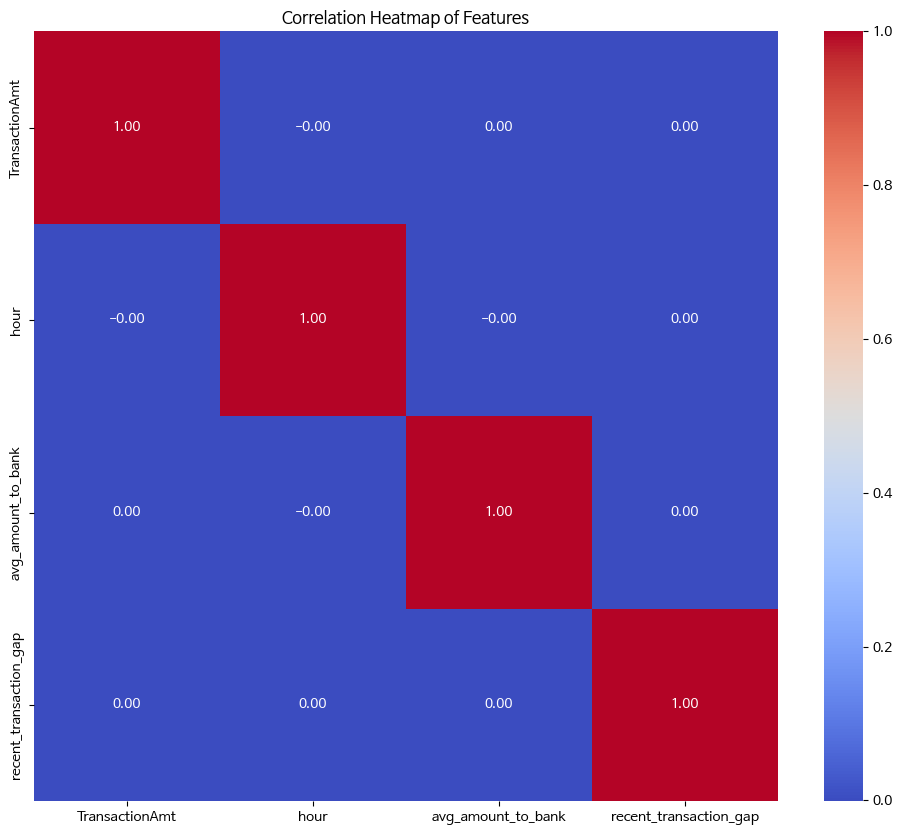

In [ ]:
# heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.show()

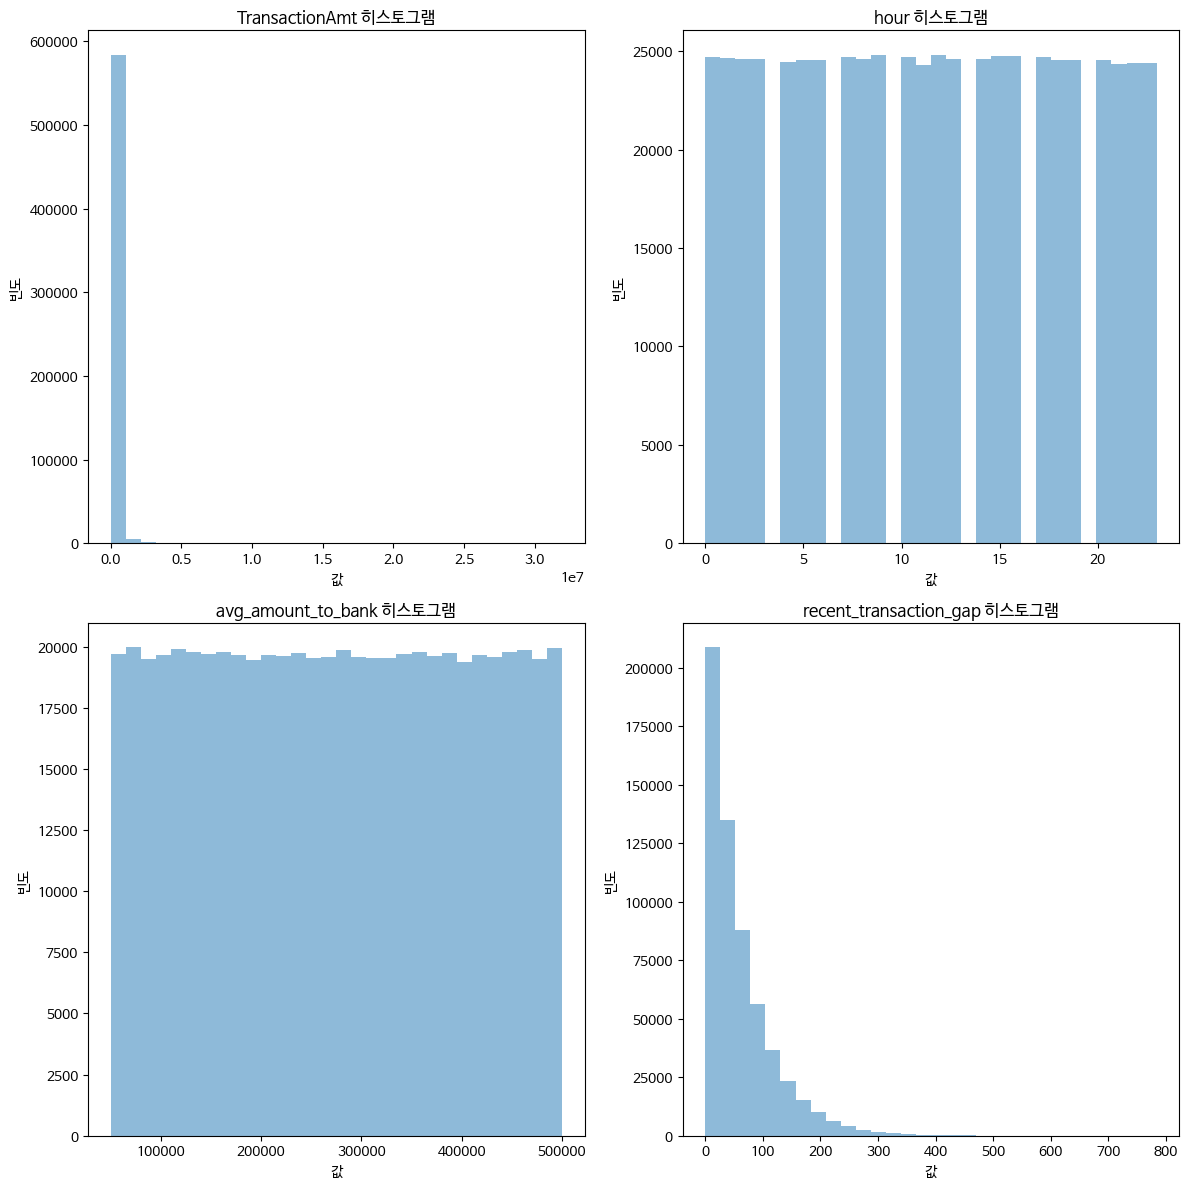

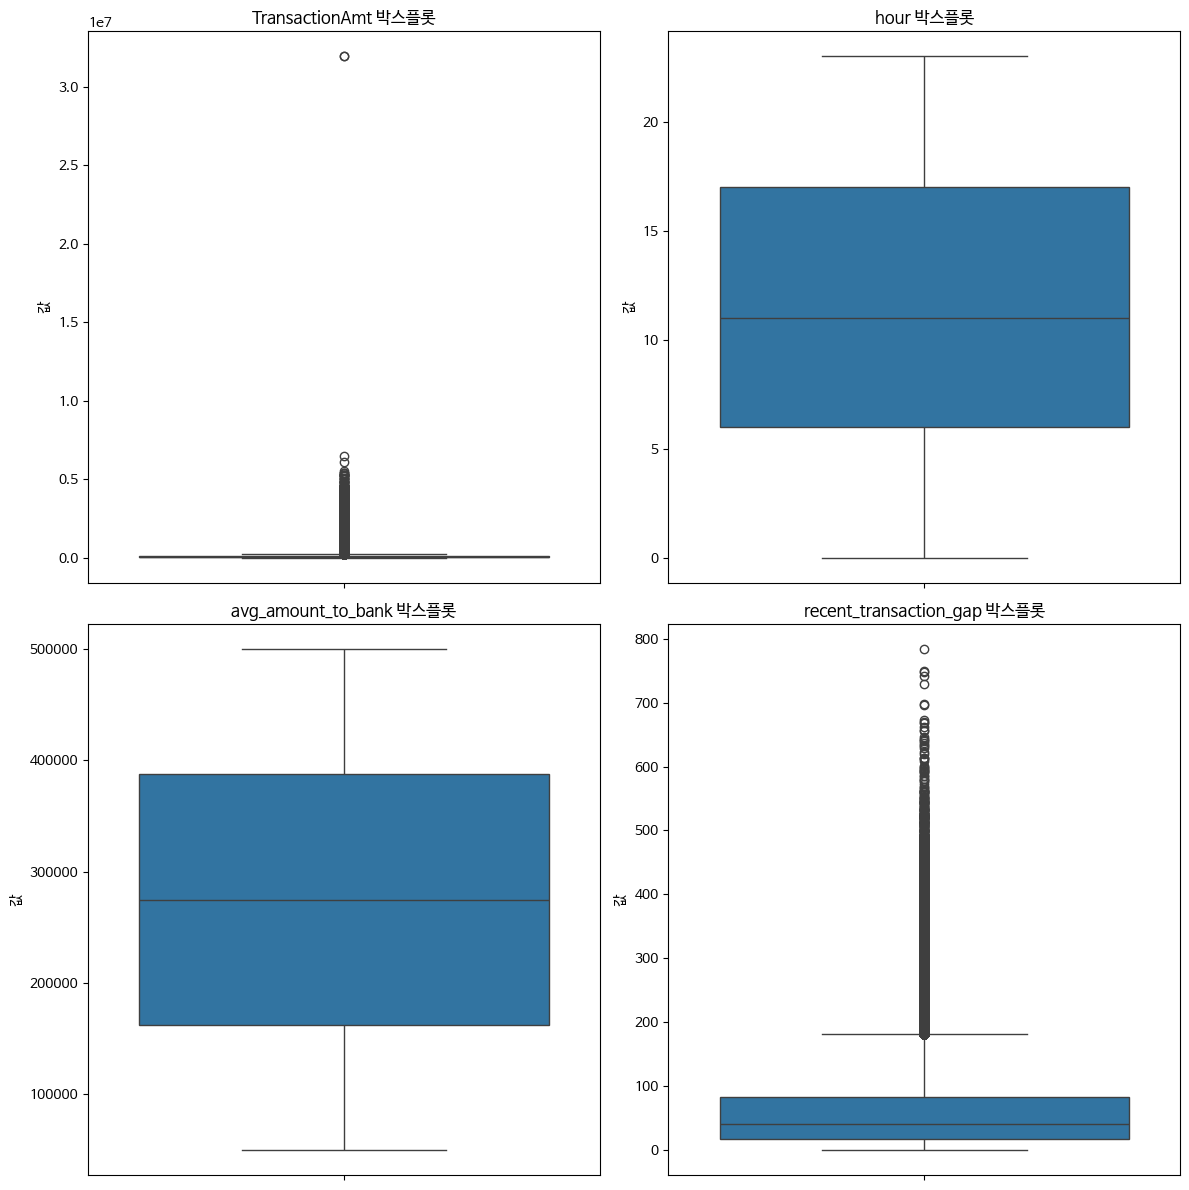

In [ ]:
# 히스토그램 (서브플롯으로 분리, 2열 배치)
num_cols = len(heatmap_df.columns)
num_rows = (num_cols + 1) // 2
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))

# 각 컬럼에 대한 히스토그램 생성
for i, col in enumerate(heatmap_df.columns):
    row = i // 2
    col_index = i % 2
    ax = axes[row, col_index]

    ax.hist(heatmap_df[col], bins=30, alpha=0.5)
    ax.set_title(f'{col} 히스토그램')
    ax.set_xlabel('값')
    ax.set_ylabel('빈도')

# 빈 슬롯 삭제
if num_cols % 2 != 0:
    fig.delaxes(axes[num_rows - 1, 1])

plt.tight_layout()
plt.show()

# 박스플롯 (서브플롯으로 분리, 2열 배치)
num_cols = len(heatmap_df.columns)
num_rows = (num_cols + 1) // 2
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))

# 각 컬럼에 대한 박스플롯 생성
for i, col in enumerate(heatmap_df.columns):
    row = i // 2
    col_index = i % 2
    ax = axes[row, col_index]

    sns.boxplot(y=heatmap_df[col], ax=ax)
    ax.set_title(f'{col} 박스플롯')
    ax.set_ylabel('값')

# 빈 슬롯 삭제
if num_cols % 2 != 0:
    fig.delaxes(axes[num_rows - 1, 1])

plt.tight_layout()
plt.show()

In [ ]:
df_mapping.head(1)

,transaction_time,TransactionDT,recipient,TransactionAmt,hour,DeviceInfo,region,receiver_bank,receiver_account,avg_amount_to_bank,amount_ratio_to_bank_avg,recent_transaction_gap,ip_address,app_version,voice_match,is_new_account_for_user,is_nighttime,is_new_device,vpn,rooting,payment_method_P02,payment_method_P03,payment_method_P04,payment_method_P05,payment_method_P06,intent_T02,intent_T03,intent_T04,intent_T05,authentication_A02,authentication_A03,authentication_A04,authentication_A05,authentication_A06
0,2025-01-14 09:56:23,86400,춘자,68500.0,9,Unknown,대구,토스뱅크,1000000266274,481616,0.142229,14.932585,58.232.2.170,3.1.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1


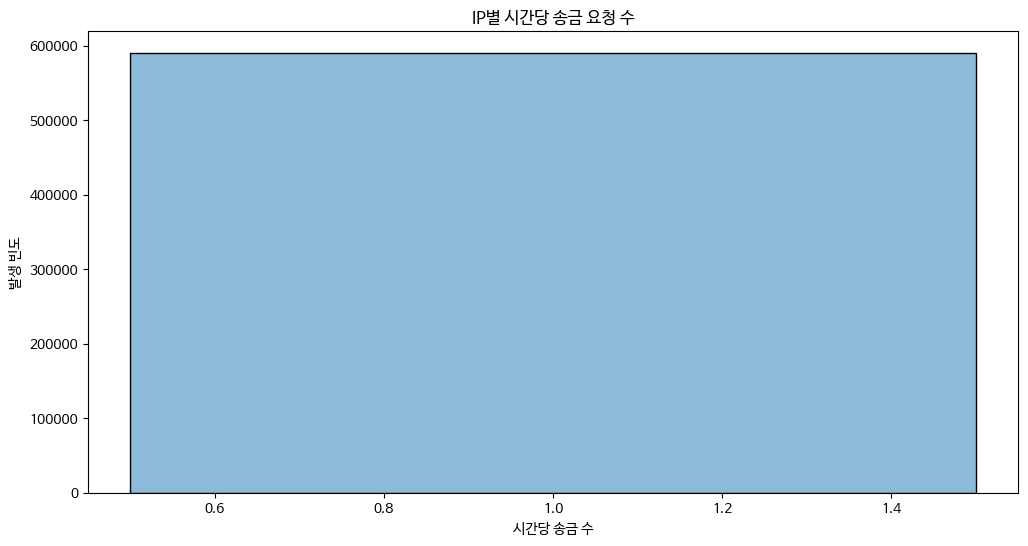

In [ ]:
# ip주소 기준 거래 시간, 거래 횟수 grouping
df_mapping['transaction_time'] = pd.to_datetime(df_mapping['transaction_time'])
hourly_transactions = df_mapping.groupby(['ip_address', pd.Grouper(key='transaction_time', freq='h')]).size().reset_index(name='transaction_count')

# 거래 빈도 분포
plt.figure(figsize=(12, 6))
sns.histplot(hourly_transactions['transaction_count'], kde=True)
plt.title('IP별 시간당 송금 요청 수')
plt.xlabel('시간당 송금 수')
plt.ylabel('발생 빈도')
plt.show()

#### Categorial

In [ ]:
cat_df

,voice_match,is_new_account_for_user,is_nighttime,is_new_device,vpn,payment_method,intent,authentication,rooting
0,True,False,0,False,False,P04,T05,A06,False
1,False,True,0,False,False,P05,T02,A02,False
2,True,False,0,False,True,P01,T05,A06,True
3,True,False,1,True,True,P05,T05,A02,True
4,True,False,0,True,True,P04,T02,A02,True
...,...,...,...,...,...,...,...,...,...
590535,False,True,0,True,True,P01,T05,A06,True
590536,False,False,0,False,True,P06,T05,A01,False
590537,False,True,0,False,False,P05,T05,A03,True
590538,True,False,0,False,False,P02,T03,A03,True


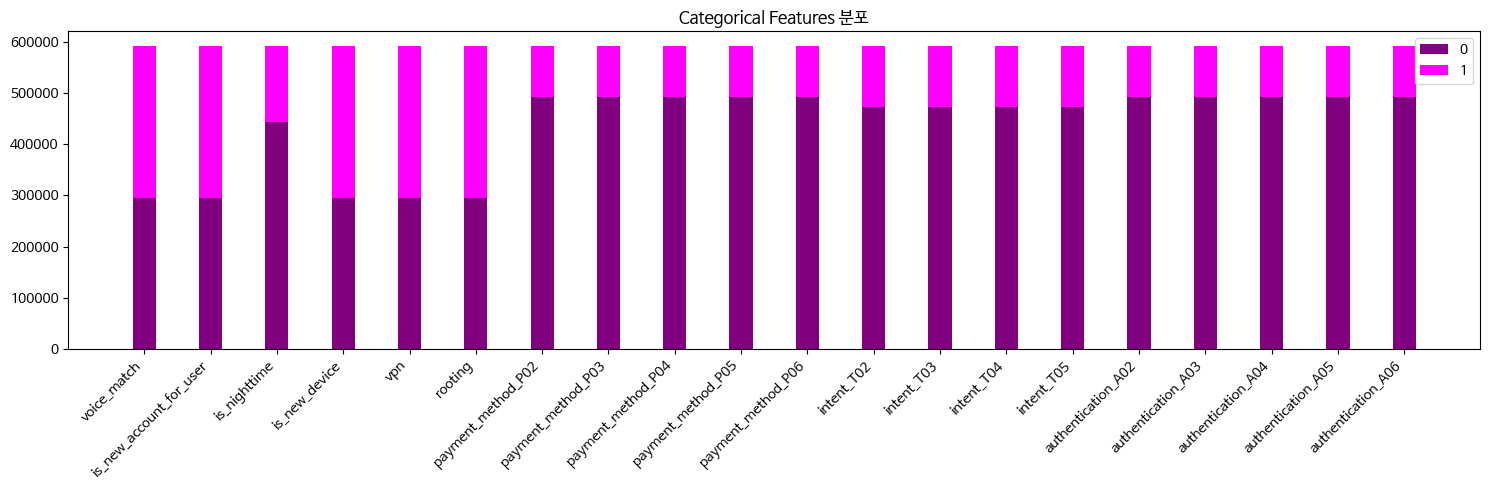

In [ ]:
# cat_df의 각 컬럼별 값의 개수를 세어 데이터프레임 생성
cat_counts = cat_df.apply(pd.value_counts).T.fillna(0)

# 컬럼명을 index로 이동
cat_counts = cat_counts.reset_index().rename(columns={'index': 'Category'})

# --- 누적 막대 그래프 생성 (단일 플롯) ---
fig, ax = plt.subplots(figsize=(15, 5))  # 단일 플롯 생성

# 각 컬럼에 대해 0과 1 값을 분리하여 누적 막대 생성
width = 0.35  # 막대 너비 조정
x_pos = np.arange(len(cat_counts['Category']))  # x축 위치 설정

# 컬럼별 색상 지정 (선택 사항)
colors = ['purple', 'magenta'] #'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'gray'

bottom = np.zeros(len(cat_counts['Category']))  # 누적 막대 시작 위치 초기화

for i, col in enumerate(cat_counts.columns[1:]):  # 'Category' 컬럼 제외
    values = cat_counts[col]  # 해당 컬럼의 값들

    # 0 값과 1 값을 분리하지 않고 전체 값을 사용하여 막대 생성
    ax.bar(x_pos, values, width, bottom=bottom, color=colors[i % len(colors)], label=col)

    bottom += values  # 다음 컬럼 막대의 시작 위치 업데이트

ax.set_xticks(x_pos)
ax.set_xticklabels(cat_counts['Category'], rotation=45, ha='right')

ax.set_title('Categorical Features 분포')
ax.legend()
plt.tight_layout()
plt.show()

## 데이터셋 저장

In [ ]:
df_mapping.to_csv('/content/df_mapping.csv', index=False)